In [34]:
using FITSIO
"""
Abstract type for all event list implementations
"""
abstract type AbstractEventList{T} end

"""
    DictMetadata

A structure containing metadata from FITS file headers.

## Fields

- `headers::Vector{Dict{String,Any}}`: A vector of dictionaries containing header information from each HDU.
"""
struct DictMetadata
    headers::Vector{Dict{String,Any}}
end

"""
    EventList{T} <: AbstractEventList{T}

A structure containing event data from a FITS file.

## Fields

- `filename::String`: Path to the source FITS file.
- `times::Vector{T}`: Vector of event times.
- `energies::Vector{T}`: Vector of event energies.
- `metadata::DictMetadata`: Metadata information extracted from the FITS file headers.
"""
struct EventList{T} <: AbstractEventList{T}
    filename::String
    times::Vector{T}
    energies::Vector{T}
    metadata::DictMetadata
end

times(ev::EventList) = ev.times
energies(ev::EventList) = ev.energies

"""
    readevents(path; T = Float64)

Read event data from a FITS file into an EventList structure.

## Arguments
- `path::String`: Path to the FITS file
- `T::Type=Float64`: Numeric type for the data

## Returns
- [`EventList`](@ref) containing the extracted data

## Notes

The function extracts `TIME` and `ENERGY` columns from any TableHDU in the FITS
file. All headers from each HDU are collected into the metadata field. It will
use the first occurrence of complete event data (both TIME and ENERGY columns)
found in the file.
"""
function readevents(path; T = Float64)
    headers = Dict{String,Any}[]
    times = T[]
    energies = T[]

    FITS(path, "r") do f
        for i = 1:length(f)  # Iterate over HDUs
            hdu = f[i]
            # Always collect headers from all extensions
            header_dict = Dict{String,Any}()
            for key in keys(read_header(hdu))
                header_dict[string(key)] = read_header(hdu)[key]
            end
            push!(headers, header_dict)

            # Check if the HDU is a table
            if isa(hdu, TableHDU)
                colnames = FITSIO.colnames(hdu)

                # Read TIME and ENERGY data if columns exist and vectors are empty
                if isempty(times) && ("TIME" in colnames)
                    times = convert(Vector{T}, read(hdu, "TIME"))
                end
                if isempty(energies) && ("ENERGY" in colnames)
                    energies = convert(Vector{T}, read(hdu, "ENERGY"))
                end

                # If we found both time and energy data, we can return
                if !isempty(times) && !isempty(energies)
                    @info "Found complete event data in extension $(i) of $(path)"
                    metadata = DictMetadata(headers)
                    return EventList{T}(path, times, energies, metadata)
                end
            end
        end
    end

    if isempty(times)
        @warn "No TIME data found in FITS file $(path). Time series analysis will not be possible."
    end
    if isempty(energies)
        @warn "No ENERGY data found in FITS file $(path). Energy spectrum analysis will not be possible."
    end

    metadata = DictMetadata(headers)
    return EventList{T}(path, times, energies, metadata)
end

Base.length(ev::AbstractEventList) = length(times(ev))
Base.size(ev::AbstractEventList) = (length(ev),)
Base.getindex(ev::EventList, i) = (ev.times[i], ev.energies[i])

function Base.show(io::IO, ev::EventList{T}) where T
    print(io, "EventList{$T}(n=$(length(ev)), file=$(ev.filename))")
end

"""
    validate(events::AbstractEventList)

Validate the event list structure.

## Returns
- `true` if valid, throws ArgumentError otherwise
"""
function validate(events::AbstractEventList)
    evt_times = times(events)
    if !issorted(evt_times)
        throw(ArgumentError("Event times must be sorted in ascending order"))
    end
    if length(evt_times) == 0
        throw(ArgumentError("Event list is empty"))
    end
    return true
end

validate

In [35]:
using Test
@testset "EventList Tests" begin
    # Test 1: Create a sample FITS file for testing
    @testset "Sample FITS file creation" begin
        test_dir = mktempdir()
        sample_file = joinpath(test_dir, "sample.fits")
        f = FITS(sample_file, "w")
        write(f, Int[])  # Empty primary array
        # Create a binary table HDU with TIME and ENERGY columns
        times = Float64[1.0, 2.0, 3.0, 4.0, 5.0]
        energies = Float64[10.0, 20.0, 15.0, 25.0, 30.0]
        # Add a binary table extension
        table = Dict{String,Array}()
        table["TIME"] = times
        table["ENERGY"] = energies
        write(f, table)
        close(f)

        @test isfile(sample_file)

        # Test reading the sample file
        data = readevents(sample_file)
        @test data.filename == sample_file
        @test length(data.times) == 5
        @test length(data.energies) == 5
        @test eltype(data.times) == Float64
        @test eltype(data.energies) == Float64
    end

    # Test 2: Test with different data types
    @testset "Different data types" begin
        test_dir = mktempdir()
        sample_file = joinpath(test_dir, "sample_float32.fits")
        f = FITS(sample_file, "w")
        write(f, Int[])
        # Create data
        times = Float64[1.0, 2.0, 3.0]
        energies = Float64[10.0, 20.0, 30.0]
        table = Dict{String,Array}()
        table["TIME"] = times
        table["ENERGY"] = energies
        write(f, table)
        close(f)
        # Test with Float32
        data_f32 = readevents(sample_file, T = Float32)
        @test eltype(data_f32.times) == Float32
        @test eltype(data_f32.energies) == Float32
        # Test with Int64
        data_i64 = readevents(sample_file, T = Int64)
        @test eltype(data_i64.times) == Int64
        @test eltype(data_i64.energies) == Int64
    end

    # Test 3: Missing Columns
    @testset "Missing columns" begin
        test_dir = mktempdir()
        sample_file = joinpath(test_dir, "sample_no_energy.fits")
        # Create a sample FITS file with only TIME column
        f = FITS(sample_file, "w")
        write(f, Int[])
        times = Float64[1.0, 2.0, 3.0]
        table = Dict{String,Array}()
        table["TIME"] = times
        write(f, table)
        close(f)
        local data
        @test_logs (:warn, "No ENERGY data found in FITS file $(sample_file). Energy spectrum analysis will not be possible.") begin
            data = readevents(sample_file)
        end
        @test length(data.times) == 3
        @test length(data.energies) == 0

        # Create a file with only ENERGY column
        sample_file2 = joinpath(test_dir, "sample_no_time.fits")
        f = FITS(sample_file2, "w")
        write(f, Int[])  # Empty primary array
        energies = Float64[10.0, 20.0, 30.0]
        table = Dict{String,Array}()
        table["ENERGY"] = energies
        write(f, table)
        close(f)
        local data2
        @test_logs (:warn, "No TIME data found in FITS file $(sample_file2). Time series analysis will not be possible.") begin
            data2 = readevents(sample_file2)
        end
        @test length(data2.times) == 0  # No TIME column
        @test length(data2.energies) == 3
    end

    # Test 4: Multiple HDUs
    @testset "Multiple HDUs" begin
        test_dir = mktempdir()
        sample_file = joinpath(test_dir, "sample_multi_hdu.fits")
        # Create a sample FITS file with multiple HDUs
        f = FITS(sample_file, "w")
        write(f, Int[])
        times1 = Float64[1.0, 2.0, 3.0]
        energies1 = Float64[10.0, 20.0, 30.0]
        table1 = Dict{String,Array}()
        table1["TIME"] = times1
        table1["ENERGY"] = energies1
        write(f, table1)
        # Second table HDU (with OTHER column)
        other_data = Float64[100.0, 200.0, 300.0]
        table2 = Dict{String,Array}()
        table2["OTHER"] = other_data
        write(f, table2)
        # Third table HDU (with TIME only)
        times3 = Float64[4.0, 5.0, 6.0]
        table3 = Dict{String,Array}()
        table3["TIME"] = times3
        write(f, table3)
        close(f)
        
        # Diagnostic printing
        data = readevents(sample_file)
        @test length(data.metadata.headers) >= 2  # At least primary and first extension
        @test length(data.metadata.headers) <= 4  # No more than primary + 3 extensions
        # Should read the first HDU with both TIME and ENERGY
        @test length(data.times) == 3
        @test length(data.energies) == 3
    end

    # Test 5: Test with monol_testA.evt
    @testset "test monol_testA.evt" begin
        test_filepath = joinpath("data", "monol_testA.evt")
        if isfile(test_filepath)
            data = readevents(test_filepath)
            @test data.filename == test_filepath
            @test length(data.metadata.headers) > 0
            @test !isempty(data.times)
        else
            @info "Test file '$(test_filepath)' not found. Skipping this test."
        end
    end

    # Test 6: Error handling
    @testset "Error handling" begin
        # Test with non-existent file - using a more generic approach
        @test_throws Exception readevents("non_existent_file.fits")

        # Test with invalid FITS file
        invalid_file = tempname()
        open(invalid_file, "w") do io
            write(io, "This is not a FITS file")
        end
        @test_throws Exception readevents(invalid_file)
    end

    # Test 7: Struct Type Validation
    @testset "EventList Struct Type Checks" begin
        # Create a sample FITS file for type testing
        test_dir = mktempdir()
        sample_file = joinpath(test_dir, "sample_types.fits")
        
        # Prepare test data
        f = FITS(sample_file, "w")
        write(f, Int[])  # Empty primary array
        
        # Create test data
        times = Float64[1.0, 2.0, 3.0, 4.0, 5.0]
        energies = Float64[10.0, 20.0, 15.0, 25.0, 30.0]
        
        table = Dict{String,Array}()
        table["TIME"] = times
        table["ENERGY"] = energies
        write(f, table)
        close(f)

        # Test type-specific instantiations
        @testset "Type Parametric Struct Tests" begin
            # Test Float64 EventList
            data_f64 = readevents(sample_file, T = Float64)
            @test isa(data_f64, EventList{Float64})
            @test typeof(data_f64) == EventList{Float64}
            
            # Test Float32 EventList
            data_f32 = readevents(sample_file, T = Float32)
            @test isa(data_f32, EventList{Float32})
            @test typeof(data_f32) == EventList{Float32}
            
            # Test Int64 EventList
            data_i64 = readevents(sample_file, T = Int64)
            @test isa(data_i64, EventList{Int64})
            @test typeof(data_i64) == EventList{Int64}
        end

        # Test struct field types
        @testset "Struct Field Type Checks" begin
            data = readevents(sample_file)
            
            # Check filename type
            @test isa(data.filename, String)
            
            # Check times and energies vector types
            @test isa(data.times, Vector{Float64})
            @test isa(data.energies, Vector{Float64})
            
            # Check metadata type
            @test isa(data.metadata, DictMetadata)
            @test isa(data.metadata.headers, Vector{Dict{String,Any}})
        end
    end

    # Test 8: Validation Function
    @testset "Validation Tests" begin
        test_dir = mktempdir()
        sample_file = joinpath(test_dir, "sample_validate.fits")
        
        # Prepare test data
        f = FITS(sample_file, "w")
        write(f, Int[])
        times = Float64[1.0, 2.0, 3.0, 4.0, 5.0]
        energies = Float64[10.0, 20.0, 15.0, 25.0, 30.0]
        
        table = Dict{String,Array}()
        table["TIME"] = times
        table["ENERGY"] = energies
        write(f, table)
        close(f)

        data = readevents(sample_file)
        
        # Test successful validation
        @test validate(data) == true

        # Test with unsorted times
        unsorted_times = Float64[3.0, 1.0, 2.0]
        unsorted_energies = Float64[30.0, 10.0, 20.0]
        unsorted_data = EventList{Float64}(sample_file, unsorted_times, unsorted_energies, 
                                           DictMetadata([Dict{String,Any}()]))
        @test_throws ArgumentError validate(unsorted_data)

        # Test with empty event list
        empty_data = EventList{Float64}(sample_file, Float64[], Float64[], 
                                        DictMetadata([Dict{String,Any}()]))
        @test_throws ArgumentError validate(empty_data)
    end
end

[ Info: Found complete event data in extension 2 of C:\Users\asus4\AppData\Local\Temp\jl_FJtKNr\sample.fits
[ Info: Found complete event data in extension 2 of C:\Users\asus4\AppData\Local\Temp\jl_hkWVic\sample_float32.fits
[ Info: Found complete event data in extension 2 of C:\Users\asus4\AppData\Local\Temp\jl_hkWVic\sample_float32.fits
[ Info: Found complete event data in extension 2 of C:\Users\asus4\AppData\Local\Temp\jl_EbOuVP\sample_multi_hdu.fits


Test Summary:   | Pass  

[ Info: Test file 'data\monol_testA.evt' not found. Skipping this test.
[ Info: Found complete event data in extension 2 of C:\Users\asus4\AppData\Local\Temp\jl_FJ1qw6\sample_types.fits
[ Info: Found complete event data in extension 2 of C:\Users\asus4\AppData\Local\Temp\jl_FJ1qw6\sample_types.fits
[ Info: Found complete event data in extension 2 of C:\Users\asus4\AppData\Local\Temp\jl_FJ1qw6\sample_types.fits
[ Info: Found complete event data in extension 2 of C:\Users\asus4\AppData\Local\Temp\jl_FJ1qw6\sample_types.fits
[ Info: Found complete event data in extension 2 of C:\Users\asus4\AppData\Local\Temp\jl_QDFazN\sample_validate.fits


Total  Time
EventList Tests |   36     36  0.5s


Test.DefaultTestSet("EventList Tests", Any[Test.DefaultTestSet("Sample FITS file creation", Any[], 6, false, false, true, 1.747085374207e9, 1.747085374448e9, false, "In[35]"), Test.DefaultTestSet("Different data types", Any[], 4, false, false, true, 1.747085374448e9, 1.747085374502e9, false, "In[35]"), Test.DefaultTestSet("Missing columns", Any[], 6, false, false, true, 1.747085374502e9, 1.747085374551e9, false, "In[35]"), Test.DefaultTestSet("Multiple HDUs", Any[], 4, false, false, true, 1.747085374551e9, 1.747085374574e9, false, "In[35]"), Test.DefaultTestSet("test monol_testA.evt", Any[], 0, false, false, true, 1.747085374574e9, 1.747085374574e9, false, "In[35]"), Test.DefaultTestSet("Error handling", Any[], 2, false, false, true, 1.747085374574e9, 1.747085374594e9, false, "In[35]"), Test.DefaultTestSet("EventList Struct Type Checks", Any[Test.DefaultTestSet("Type Parametric Struct Tests", Any[], 6, false, false, true, 1.747085374594e9, 1.74708537462e9, false, "In[35]"), Test.Defaul

In [36]:
using Statistics

"""
Abstract type for all light curve implementations.
"""
abstract type AbstractLightCurve{T} end

"""
    EventProperty{T}

A structure to hold additional event properties beyond time and energy.
"""
struct EventProperty{T}
    name::Symbol
    values::Vector{T}
    unit::String
end

"""
    LightCurveMetadata

A structure containing metadata for light curves.
"""
struct LightCurveMetadata
    telescope::String
    instrument::String
    object::String
    mjdref::Float64
    time_range::Tuple{Float64,Float64}
    bin_size::Float64
    headers::Vector{Dict{String,Any}}
    extra::Dict{String,Any}
end

"""
    LightCurve{T} <: AbstractLightCurve{T}

A structure representing a binned time series with additional properties.
"""
struct LightCurve{T} <: AbstractLightCurve{T}
    timebins::Vector{T}
    bin_edges::Vector{T}
    counts::Vector{Int}
    count_error::Vector{T}
    exposure::Vector{T}
    properties::Vector{EventProperty}
    metadata::LightCurveMetadata
    err_method::Symbol
end

"""
    calculate_errors(counts::Vector{Int}, method::Symbol, exposure::Vector{T}) where T

Calculate statistical uncertainties for count data.
"""
function calculate_errors(counts::Vector{Int}, method::Symbol, exposure::Vector{T}) where T
    if method === :poisson
        return convert.(T, sqrt.(counts))
    elseif method === :gaussian
        return convert.(T, sqrt.(counts .+ 1))
    else
        throw(ArgumentError("Unsupported error method: $method. Use :poisson or :gaussian"))
    end
end

"""
    create_lightcurve(
        eventlist::EventList{T}, 
        binsize::Real;
        err_method::Symbol=:poisson,
        tstart::Union{Nothing,Real}=nothing,
        tstop::Union{Nothing,Real}=nothing,
        filters::Dict{Symbol,Any}=Dict{Symbol,Any}()
    ) where T

Create a light curve from an event list with filtering capabilities.
"""
function create_lightcurve(
    eventlist::EventList{T}, 
    binsize::Real;
    err_method::Symbol=:poisson,
    tstart::Union{Nothing,Real}=nothing,
    tstop::Union{Nothing,Real}=nothing,
    filters::Dict{Symbol,Any}=Dict{Symbol,Any}()
) where T
    
    if isempty(eventlist.times)
        throw(ArgumentError("Event list is empty"))
    end
    
    if binsize <= 0
        throw(ArgumentError("Bin size must be positive"))
    end
    
    # Initial filtering step
    times = copy(eventlist.times)
    energies = copy(eventlist.energies)
    
    # Apply time range filter
    start_time = isnothing(tstart) ? minimum(times) : convert(T, tstart)
    stop_time = isnothing(tstop) ? maximum(times) : convert(T, tstop)
    
    # Filter indices based on all criteria
    valid_indices = findall(t -> start_time ≤ t ≤ stop_time, times)
    
    # Apply additional filters
    for (key, value) in filters
        if key == :energy
            if value isa Tuple
                energy_indices = findall(e -> value[1] ≤ e < value[2], energies)
                valid_indices = intersect(valid_indices, energy_indices)
            end
        end
    end
    
    total_events = length(times)
    filtered_events = length(valid_indices)
    
    #[this below function needs to be discussed properly!]
    # Create bins regardless of whether we have events[i have enter this what if we got unexpectedly allmevents filter out ]
    binsize_t = convert(T, binsize)
    
    # Make sure we have at least one bin even if start_time equals stop_time
    if start_time == stop_time
        stop_time = start_time + binsize_t
    end
    
    # Ensure the edges encompass the entire range
    start_bin = floor(start_time / binsize_t) * binsize_t
    num_bins = ceil(Int, (stop_time - start_bin) / binsize_t)
    edges = [start_bin + i * binsize_t for i in 0:num_bins]
    centers = edges[1:end-1] .+ binsize_t/2
    
    # Count events in bins
    counts = zeros(Int, length(centers))
    
    # Only process events if we have any after filtering
    if !isempty(valid_indices)
        filtered_times = times[valid_indices]
        
        for t in filtered_times
            bin_idx = floor(Int, (t - start_bin) / binsize_t) + 1
            if 1 ≤ bin_idx ≤ length(counts)
                counts[bin_idx] += 1
            end
        end
    end
    
    # Calculate exposures and errors
    exposure = fill(binsize_t, length(centers))
    errors = calculate_errors(counts, err_method, exposure)
    
    # Create additional properties
    properties = Vector{EventProperty}()
    
    # Calculate mean energy per bin if available
    if !isempty(valid_indices) && !isempty(energies)
        filtered_times = times[valid_indices]
        filtered_energies = energies[valid_indices]
        
        energy_bins = zeros(T, length(centers))
        energy_counts = zeros(Int, length(centers))
        
        for (t, e) in zip(filtered_times, filtered_energies)
            bin_idx = floor(Int, (t - start_bin) / binsize_t) + 1
            if 1 ≤ bin_idx ≤ length(counts)
                energy_bins[bin_idx] += e
                energy_counts[bin_idx] += 1
            end
        end
        
        mean_energy = zeros(T, length(centers))
        for i in eachindex(mean_energy)
            mean_energy[i] = energy_counts[i] > 0 ? energy_bins[i] / energy_counts[i] : zero(T)
        end
        
        push!(properties, EventProperty{T}(:mean_energy, mean_energy, "keV"))
    end
    
    # Create extra metadata with warning if no events remain after filtering
    extra = Dict{String,Any}(
        "filtered_nevents" => filtered_events,
        "total_nevents" => total_events,
        "applied_filters" => filters
    )
    
    if filtered_events == 0
        extra["warning"] = "No events remain after filtering"
    end
    
    # Create metadata
    metadata = LightCurveMetadata(
        get(eventlist.metadata.headers[1], "TELESCOP", ""),
        get(eventlist.metadata.headers[1], "INSTRUME", ""),
        get(eventlist.metadata.headers[1], "OBJECT", ""),
        get(eventlist.metadata.headers[1], "MJDREF", 0.0),
        (start_time, stop_time),
        binsize_t,
        eventlist.metadata.headers,
        extra
    )
    
    return LightCurve{T}(
        centers,
        collect(edges),
        counts,
        errors,
        exposure,
        properties,
        metadata,
        err_method
    )
end

"""
    rebin(lc::LightCurve{T}, new_binsize::Real) where T

Rebin a light curve to a new time resolution.
"""
function rebin(lc::LightCurve{T}, new_binsize::Real) where T
    if new_binsize <= lc.metadata.bin_size
        throw(ArgumentError("New bin size must be larger than current bin size"))
    end
    
    old_binsize = lc.metadata.bin_size
    new_binsize_t = convert(T, new_binsize)
    
    # Create new bin edges using the same approach as in create_lightcurve
    start_time = lc.metadata.time_range[1]
    stop_time = lc.metadata.time_range[2]
    
    # Calculate bin edges using the same algorithm as in create_lightcurve
    start_bin = floor(start_time / new_binsize_t) * new_binsize_t
    num_bins = ceil(Int, (stop_time - start_bin) / new_binsize_t)
    new_edges = [start_bin + i * new_binsize_t for i in 0:num_bins]
    new_centers = new_edges[1:end-1] .+ new_binsize_t/2
    
    # Rebin counts
    new_counts = zeros(Int, length(new_centers))
    
    for (i, time) in enumerate(lc.timebins)
        if lc.counts[i] > 0  # Only process bins with counts
            bin_idx = floor(Int, (time - start_bin) / new_binsize_t) + 1
            if 1 ≤ bin_idx ≤ length(new_counts)
                new_counts[bin_idx] += lc.counts[i]
            end
        end
    end
    
    # Calculate new exposures and errors
    new_exposure = fill(new_binsize_t, length(new_centers))
    new_errors = calculate_errors(new_counts, lc.err_method, new_exposure)
    
    # Rebin properties
    new_properties = Vector{EventProperty}()
    for prop in lc.properties
        new_values = zeros(T, length(new_centers))
        counts = zeros(Int, length(new_centers))
        
        for (i, val) in enumerate(prop.values)
            if lc.counts[i] > 0  # Only process bins with counts
                bin_idx = floor(Int, (lc.timebins[i] - start_bin) / new_binsize_t) + 1
                if 1 ≤ bin_idx ≤ length(new_values)
                    new_values[bin_idx] += val * lc.counts[i]
                    counts[bin_idx] += lc.counts[i]
                end
            end
        end
        
        # Calculate weighted average
        for i in eachindex(new_values)
            new_values[i] = counts[i] > 0 ? new_values[i] / counts[i] : zero(T)
        end
        
        push!(new_properties, EventProperty(prop.name, new_values, prop.unit))
    end
    
    # Update metadata
    new_metadata = LightCurveMetadata(
        lc.metadata.telescope,
        lc.metadata.instrument,
        lc.metadata.object,
        lc.metadata.mjdref,
        lc.metadata.time_range,
        new_binsize_t,
        lc.metadata.headers,
        merge(
            lc.metadata.extra,
            Dict{String,Any}("original_binsize" => old_binsize)
        )
    )
    
    return LightCurve{T}(
        new_centers,
        collect(new_edges),
        new_counts,
        new_errors,
        new_exposure,
        new_properties,
        new_metadata,
        lc.err_method
    )
end

# Basic array interface methods
Base.length(lc::LightCurve) = length(lc.counts)
Base.size(lc::LightCurve) = (length(lc),)
Base.getindex(lc::LightCurve, i) = (lc.timebins[i], lc.counts[i])

In [37]:
using Test
using FITSIO
using Statistics

@testset "Complete LightCurve Tests" begin
    @testset "Basic Light Curve Creation" begin
        test_dir = mktempdir()
        sample_file = joinpath(test_dir, "sample.fits")
        f = FITS(sample_file, "w")
        write(f, Int[])
        
        # Create test data
        times = Float64[1.0, 2.0, 3.0, 4.0, 5.0]
        energies = Float64[10.0, 20.0, 15.0, 25.0, 30.0]
        
        table = Dict{String,Array}()
        table["TIME"] = times
        table["ENERGY"] = energies
        write(f, table)
        close(f)
        
        data = readevents(sample_file)
        
        # Create light curve
        lc = create_lightcurve(data, 1.0)
        
        # Calculate expected bins
        expected_bins = Int(ceil((maximum(times) - minimum(times))/1.0))
        
        # Test structure
        @test length(lc.timebins) == expected_bins
        @test length(lc.counts) == expected_bins
        @test length(lc.bin_edges) == expected_bins + 1
        
        # Test bin centers
        @test lc.timebins[1] ≈ 1.5
        @test lc.timebins[end] ≈ 4.5
        
        # Test counts
        expected_counts = fill(1, expected_bins)
        @test all(lc.counts .== expected_counts)
        
        # Test errors
        @test all(lc.count_error .≈ sqrt.(Float64.(expected_counts)))
        
        # Test metadata and properties
        @test lc.err_method === :poisson
        @test length(lc) == expected_bins
        @test size(lc) == (expected_bins,)
        @test lc[1] == (1.5, 1)
    end

    @testset "Time Range and Binning" begin
        times = Float64[1.0, 2.0, 3.0, 4.0, 5.0]
        energies = Float64[10.0, 20.0, 15.0, 25.0, 30.0]
        events = EventList{Float64}("test.fits", times, energies, 
            DictMetadata([Dict{String,Any}()]))

        # Test specific time range
        lc = create_lightcurve(events, 1.0, tstart=2.0, tstop=4.0)
        expected_bins = Int(ceil((4.0 - 2.0)/1.0))
        @test length(lc.timebins) == expected_bins
        @test lc.metadata.time_range == (2.0, 4.0)
        @test all(2.0 .<= lc.bin_edges .<= 4.0)
        @test sum(lc.counts) == 2

        # Test equal start and stop times
        lc_equal = create_lightcurve(events, 1.0, tstart=2.0, tstop=2.0)
        @test length(lc_equal.counts) == 1
        @test lc_equal.metadata.time_range[2] == lc_equal.metadata.time_range[1] + 1.0

        # Test bin edges
        lc_edges = create_lightcurve(events, 2.0)
        @test lc_edges.bin_edges[end] >= maximum(times)
    end

    @testset "Filtering" begin
        times = Float64[1.0, 2.0, 3.0, 4.0, 5.0]
        energies = Float64[1.0, 2.0, 5.0, 8.0, 10.0]
        events = EventList{Float64}("test.fits", times, energies,
            DictMetadata([Dict{String,Any}()]))

        # Test energy filtering
        energy_filter = Dict{Symbol,Any}(:energy => (4.0, 9.0))
        lc = create_lightcurve(events, 1.0, filters=energy_filter)
        @test sum(lc.counts) == 2
        @test haskey(lc.metadata.extra, "filtered_nevents")
        @test lc.metadata.extra["filtered_nevents"] == 2

        # Test empty filter result
        empty_filter = Dict{Symbol,Any}(:energy => (100.0, 200.0))
        lc_empty = create_lightcurve(events, 1.0, filters=empty_filter)
        @test all(lc_empty.counts .== 0)
        @test haskey(lc_empty.metadata.extra, "warning")
        @test lc_empty.metadata.extra["warning"] == "No events remain after filtering"
    end

    @testset "Error Methods" begin
        times = Float64[1.0, 2.0, 3.0]
        energies = Float64[10.0, 20.0, 30.0]
        events = EventList{Float64}("test.fits", times, energies,
            DictMetadata([Dict{String,Any}()]))

        # Test Poisson errors
        lc_poisson = create_lightcurve(events, 1.0)
        @test all(lc_poisson.count_error .≈ sqrt.(lc_poisson.counts))

        # Test Gaussian errors
        lc_gaussian = create_lightcurve(events, 1.0, err_method=:gaussian)
        @test all(lc_gaussian.count_error .≈ sqrt.(lc_gaussian.counts .+ 1))

        # Test invalid error method
        @test_throws ArgumentError create_lightcurve(events, 1.0, 
            err_method=:invalid)
    end

    @testset "Properties and Metadata" begin
        times = Float64[1.0, 2.0, 3.0]
        energies = Float64[10.0, 20.0, 30.0]
        headers = [Dict{String,Any}(
            "TELESCOP" => "TEST",
            "INSTRUME" => "INST",
            "OBJECT" => "SRC",
            "MJDREF" => 58000.0
        )]
        events = EventList{Float64}("test.fits", times, energies,
            DictMetadata(headers))

        lc = create_lightcurve(events, 1.0)
        
        # Test metadata
        @test lc.metadata.telescope == "TEST"
        @test lc.metadata.instrument == "INST"
        @test lc.metadata.object == "SRC"
        @test lc.metadata.mjdref == 58000.0
        @test haskey(lc.metadata.extra, "filtered_nevents")
        @test haskey(lc.metadata.extra, "total_nevents")

        # Test properties
        @test !isempty(lc.properties)
        energy_prop = first(filter(p -> p.name == :mean_energy, lc.properties))
        @test energy_prop.unit == "keV"
        @test length(energy_prop.values) == length(lc.counts)
    end

    @testset "Rebinning" begin
        # Create test data with evenly spaced events
        times = Float64[1.0, 1.5, 2.0, 2.5, 3.0]
        energies = Float64[10.0, 15.0, 20.0, 25.0, 30.0]
        events = EventList{Float64}("test.fits", times, energies,
            DictMetadata([Dict{String,Any}()]))
    
        # Create initial light curve with 0.5 bin size
        lc = create_lightcurve(events, 0.5)
        
        # Calculate expected number of bins after rebinning
        time_range = lc.metadata.time_range[2] - lc.metadata.time_range[1]
        expected_bins = Int(ceil(time_range))  # For 1.0 binsize
        
        # Test rebinning
        lc_rebinned = rebin(lc, 1.0)
        @test length(lc_rebinned.counts) == expected_bins
        @test sum(lc_rebinned.counts) == sum(lc.counts)
        @test all(lc_rebinned.exposure .== 1.0)
    
        # Test property preservation
        @test length(lc_rebinned.properties) == length(lc.properties)
        if !isempty(lc.properties)
            orig_prop = first(lc.properties)
            rebin_prop = first(lc_rebinned.properties)
            @test orig_prop.name == rebin_prop.name
            @test orig_prop.unit == rebin_prop.unit
        end
    
        # Test metadata
        @test haskey(lc_rebinned.metadata.extra, "original_binsize")
        @test lc_rebinned.metadata.extra["original_binsize"] == 0.5
    
        # Test invalid rebin size
        @test_throws ArgumentError rebin(lc, 0.1)
    end
    
    @testset "Edge Cases" begin
        # Test empty event list
        empty_events = EventList{Float64}("test.fits", Float64[], Float64[],
            DictMetadata([Dict{String,Any}()]))
        @test_throws ArgumentError create_lightcurve(empty_events, 1.0)
    
        # Test single event
        # Place event exactly at bin center to ensure it's counted
        times = Float64[2.5]  # Place at 2.5 to ensure it falls in a bin center
        energies = Float64[10.0]
        single_event = EventList{Float64}("test.fits", times, energies,
            DictMetadata([Dict{String,Any}()]))
        
        lc_single = create_lightcurve(single_event, 1.0)
        
        # Calculate expected bin for the event
        start_time = floor(minimum(times))
        bin_idx = Int(floor((times[1] - start_time) / 1.0)) + 1
        expected_counts = zeros(Int, length(lc_single.counts))
        if 1 <= bin_idx <= length(expected_counts)
            expected_counts[bin_idx] = 1
        end
        
        @test lc_single.counts == expected_counts
        @test sum(lc_single.counts) == 1
    
        # Test invalid bin sizes
        events = EventList{Float64}("test.fits", [1.0, 2.0], [10.0, 20.0],
            DictMetadata([Dict{String,Any}()]))
        @test_throws ArgumentError create_lightcurve(events, 0.0)
        @test_throws ArgumentError create_lightcurve(events, -1.0)
    
        # Test complete filtering
        lc_filtered = create_lightcurve(events, 1.0,
            filters=Dict{Symbol,Any}(:energy => (100.0, 200.0)))
        @test all(lc_filtered.counts .== 0)
        @test haskey(lc_filtered.metadata.extra, "warning")
    end

    @testset "Type Stability" begin
        for T in [Float32, Float64]
            times = T[1.0, 2.0, 3.0]
            energies = T[10.0, 20.0, 30.0]
            events = EventList{T}("test.fits", times, energies,
                DictMetadata([Dict{String,Any}()]))

            # Test creation
            lc = create_lightcurve(events, T(1.0))
            @test eltype(lc.timebins) === T
            @test eltype(lc.bin_edges) === T
            @test eltype(lc.count_error) === T
            @test eltype(lc.exposure) === T

            # Test rebinning
            lc_rebinned = rebin(lc, T(2.0))
            @test eltype(lc_rebinned.timebins) === T
            @test eltype(lc_rebinned.bin_edges) === T
            @test eltype(lc_rebinned.count_error) === T
            @test eltype(lc_rebinned.exposure) === T
        end
    end

    @testset "Array Interface" begin
        times = Float64[1.0, 2.0, 3.0]
        energies = Float64[10.0, 20.0, 30.0]
        events = EventList{Float64}("test.fits", times, energies,
            DictMetadata([Dict{String,Any}()]))
        
        lc = create_lightcurve(events, 1.0)
        
        @test length(lc) == length(lc.counts)
        @test size(lc) == (length(lc.counts),)
        @test lc[1] == (lc.timebins[1], lc.counts[1])
    end
end

[ Info: Found complete event data in extension 2 of C:\Users\asus4\AppData\Local\Temp\jl_SYsU09\sample.fits


Test Summary:             | Pass  Total  Time
Complete LightCurve Tests |   71     71  2.4s


Test.DefaultTestSet("Complete LightCurve Tests", Any[Test.DefaultTestSet("Basic Light Curve Creation", Any[], 11, false, false, true, 1.747085377645e9, 1.747085378351e9, false, "In[37]"), Test.DefaultTestSet("Time Range and Binning", Any[], 7, false, false, true, 1.747085378351e9, 1.74708537866e9, false, "In[37]"), Test.DefaultTestSet("Filtering", Any[], 6, false, false, true, 1.74708537866e9, 1.747085378777e9, false, "In[37]"), Test.DefaultTestSet("Error Methods", Any[], 3, false, false, true, 1.747085378777e9, 1.747085378798e9, false, "In[37]"), Test.DefaultTestSet("Properties and Metadata", Any[], 9, false, false, true, 1.747085378798e9, 1.747085378825e9, false, "In[37]"), Test.DefaultTestSet("Rebinning", Any[], 9, false, false, true, 1.747085378825e9, 1.7470853791e9, false, "In[37]"), Test.DefaultTestSet("Edge Cases", Any[], 7, false, false, true, 1.7470853791e9, 1.7470853791e9, false, "In[37]"), Test.DefaultTestSet("Type Stability", Any[], 16, false, false, true, 1.7470853791e9, 1

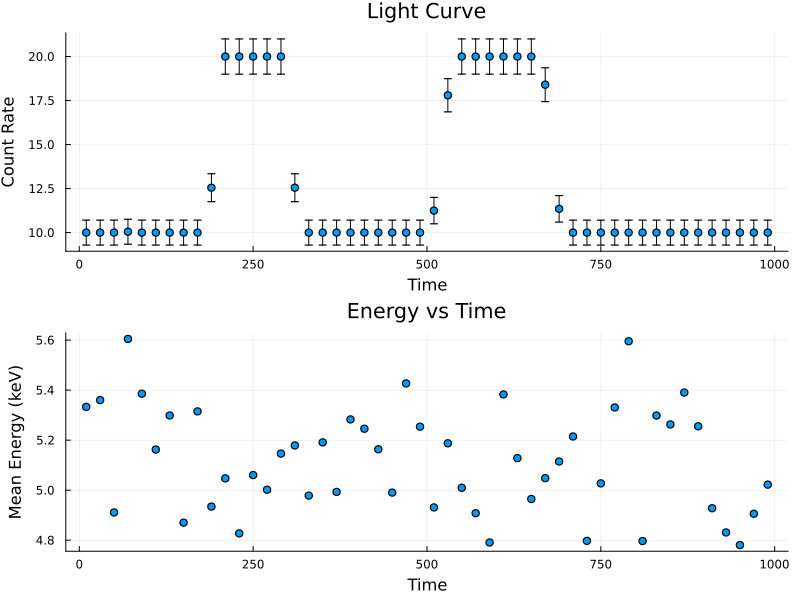

In [32]:
using Plots

"""
    plot_lightcurve(lc::LightCurve; 
        error_bars::Bool=true, 
        style::Symbol=:scatter,
        ylabel::String="Count Rate",
        xlabel::String="Time",
        title::String="Light Curve",
        markersize::Int=4)

Plot a light curve with optional error bars.
"""
function plot_lightcurve(lc::LightCurve;
    error_bars::Bool=true,
    style::Symbol=:scatter,
    ylabel::String="Count Rate",
    xlabel::String="Time",
    title::String="Light Curve",
    markersize::Int=4)
    
    # Calculate rate and rate errors
    rate = lc.counts ./ lc.exposure
    rate_error = lc.count_error ./ lc.exposure
    
    # Create plot
    p = if style === :scatter
        scatter(lc.timebins, rate,
            yerror=error_bars ? rate_error : nothing,
            label="",
            markersize=markersize,
            xlabel=xlabel,
            ylabel=ylabel,
            title=title)
    elseif style === :step
        plot(lc.timebins, rate,
            yerror=error_bars ? rate_error : nothing,
            label="",
            linetype=:steppost,
            xlabel=xlabel,
            ylabel=ylabel,
            title=title)
    else
        plot(lc.timebins, rate,
            yerror=error_bars ? rate_error : nothing,
            label="",
            xlabel=xlabel,
            ylabel=ylabel,
            title=title)
    end
    
    return p
end

"""
    plot_energy_spectrum(lc::LightCurve;
        style::Symbol=:scatter,
        ylabel::String="Mean Energy (keV)",
        xlabel::String="Time",
        title::String="Energy vs Time",
        markersize::Int=4)

Plot the mean energy per bin if available.
"""
function plot_energy_spectrum(lc::LightCurve;
    style::Symbol=:scatter,
    ylabel::String="Mean Energy (keV)",
    xlabel::String="Time",
    title::String="Energy vs Time",
    markersize::Int=4)
    
    # Find mean energy property
    energy_prop = nothing
    for prop in lc.properties
        if prop.name === :mean_energy
            energy_prop = prop
            break
        end
    end
    
    if isnothing(energy_prop)
        error("No mean energy property found in light curve")
    end
    
    # Create plot
    p = if style === :scatter
        scatter(lc.timebins, energy_prop.values,
            label="",
            markersize=markersize,
            xlabel=xlabel,
            ylabel=ylabel,
            title=title)
    else
        plot(lc.timebins, energy_prop.values,
            label="",
            xlabel=xlabel,
            ylabel=ylabel,
            title=title)
    end
    
    return p
end

"""
    plot_combined(lc::LightCurve;
        error_bars::Bool=true,
        style::Symbol=:scatter)

Create a combined plot with light curve and energy spectrum.
"""
function plot_combined(lc::LightCurve;
    error_bars::Bool=true,
    style::Symbol=:scatter)
    
    # Create subplots
    p1 = plot_lightcurve(lc, 
        error_bars=error_bars, 
        style=style,
        title="Light Curve")
    
    p2 = plot_energy_spectrum(lc,
        style=style,
        title="Energy vs Time")
    
    # Combine plots
    plot(p1, p2, layout=(2,1), size=(800,600))
end

# Example usage:
# Assuming you have created a light curve 'lc':
# Basic light curve plot
plot_lightcurve(lc)

# Step-style plot without error bars
plot_lightcurve(lc, error_bars=false, style=:step)

# Energy spectrum
plot_energy_spectrum(lc)

# Combined plot
plot_combined(lc)


Plotting light curves with different bin sizes...


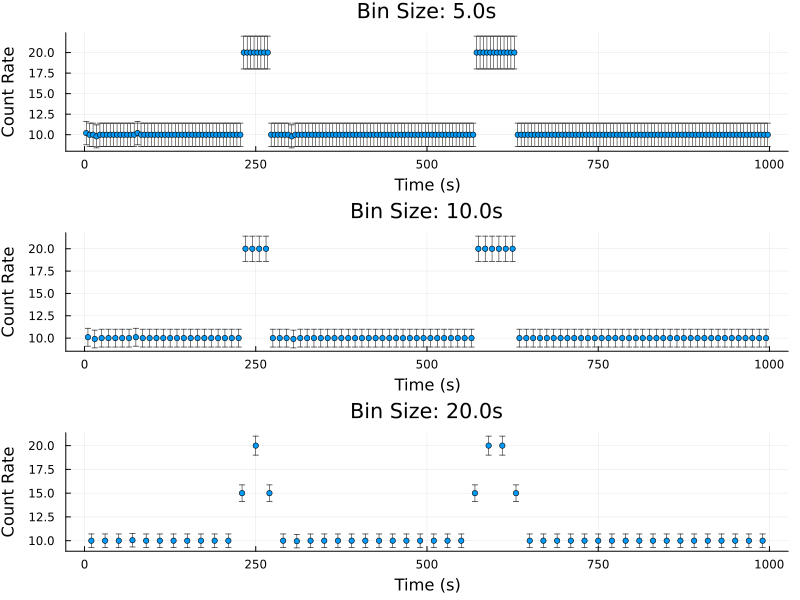


Comparing error calculation methods...


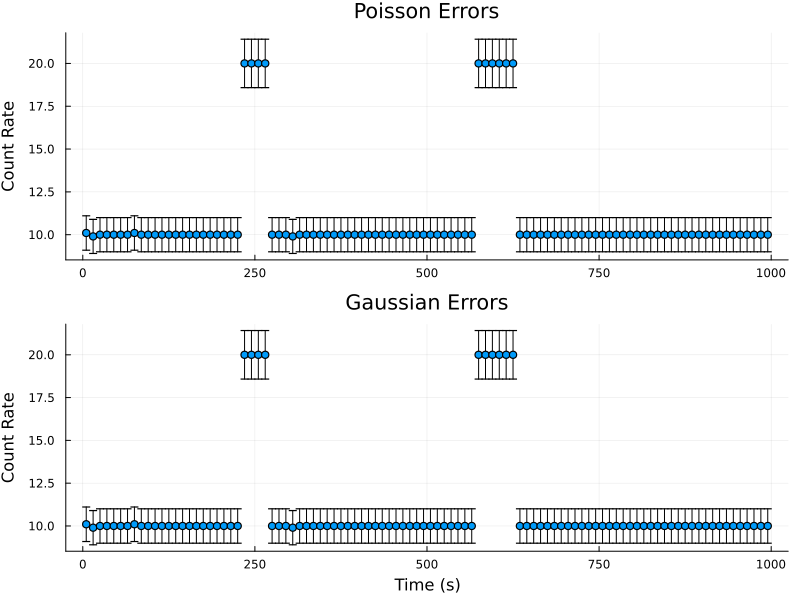


Comparing original and rebinned light curves...


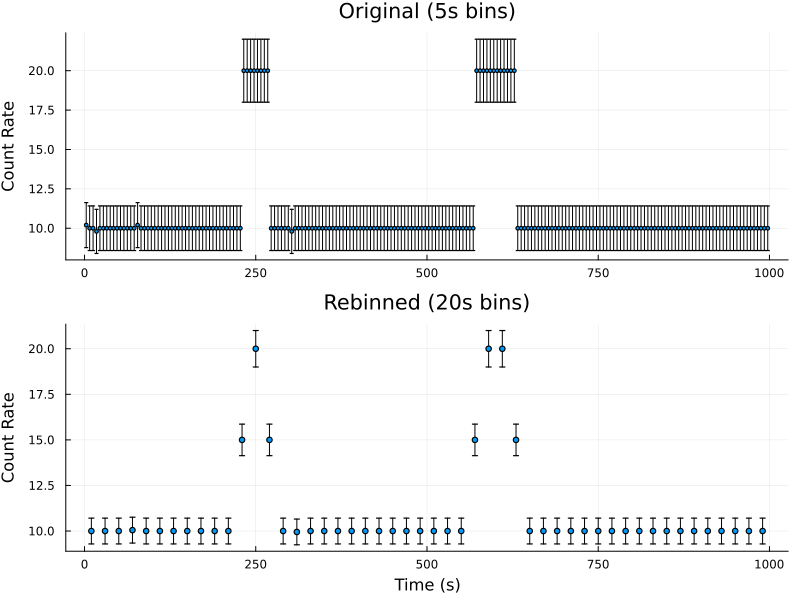


Showing different visualization styles...


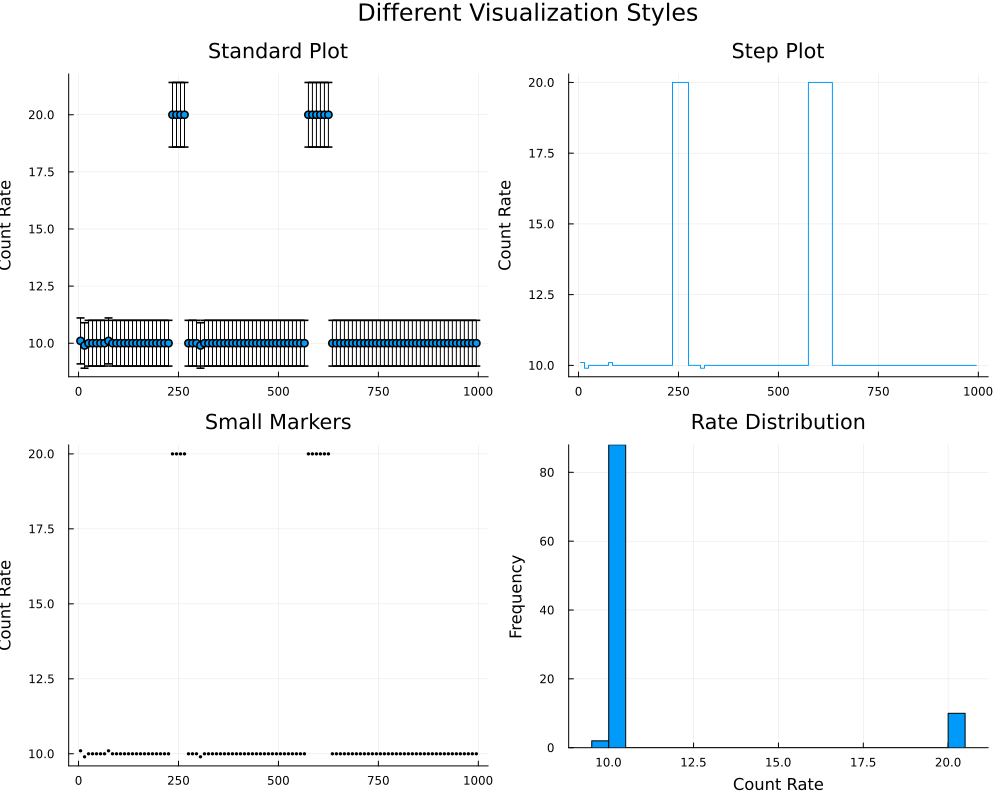

In [33]:
using Plots
using Random
using Statistics
using FITSIO

# Set random seed for reproducibility
Random.seed!(123)

"""
Generate a simulated light curve with artificial bursts
"""
function generate_test_data(;
    n_events=10000,
    time_range=(0.0, 1000.0),
    base_rate=50.0,
    burst_times=[250.0, 600.0],
    burst_amplitudes=[200.0, 150.0],
    burst_widths=[20.0, 30.0]
)
    times = Float64[]
    t = time_range[1]
    
    while t < time_range[2]
        if rand() < (base_rate * 0.1)
            # Add bursts
            for (bt, ba, bw) in zip(burst_times, burst_amplitudes, burst_widths)
                if abs(t - bt) < bw
                    if rand() < (ba * exp(-(t - bt)^2/(2*bw^2)) * 0.1)
                        push!(times, t)
                    end
                end
            end
            push!(times, t)
        end
        t += 0.1
    end
    
    sort!(times)
    energies = rand(length(times)) .* 10.0 .+ 0.1
    
    headers = [Dict{String,Any}(
        "TELESCOP" => "SIMULATOR",
        "INSTRUME" => "TEST",
        "OBJECT" => "Test Source",
        "EXPOSURE" => time_range[2] - time_range[1]
    )]
    
    EventList{Float64}("simulated.fits", times, energies, DictMetadata(headers))
end

# Plot functions
"""
Plot light curve with different bin sizes
"""
function plot_binsize_comparison(events, binsizes=[5.0, 10.0, 20.0])
    plots = []
    for binsize in binsizes
        lc = create_lightcurve(events, binsize)
        rate = lc.counts ./ lc.exposure
        rate_error = lc.count_error ./ lc.exposure
        
        p = scatter(lc.timebins, rate,
            yerror=rate_error,
            title="Bin Size: $(binsize)s",
            ylabel="Count Rate",
            xlabel="Time (s)",
            label="",
            markersize=3,
            markerstrokewidth=0.5)
        push!(plots, p)
    end
    
    plot(plots..., 
        layout=(length(binsizes), 1), 
        size=(800, 200*length(binsizes)),
        link=:x)
end

"""
Compare error methods
"""
function plot_error_comparison(events)
    lc_poisson = create_lightcurve(events, 10.0, err_method=:poisson)
    lc_gauss = create_lightcurve(events, 10.0, err_method=:gaussian)
    
    rate_p = lc_poisson.counts ./ lc_poisson.exposure
    rate_g = lc_gauss.counts ./ lc_gauss.exposure
    error_p = lc_poisson.count_error ./ lc_poisson.exposure
    error_g = lc_gauss.count_error ./ lc_gauss.exposure
    
    p1 = scatter(lc_poisson.timebins, rate_p,
        yerror=error_p,
        title="Poisson Errors",
        ylabel="Count Rate",
        label="")
        
    p2 = scatter(lc_gauss.timebins, rate_g,
        yerror=error_g,
        title="Gaussian Errors",
        ylabel="Count Rate",
        xlabel="Time (s)",
        label="")
        
    plot(p1, p2, layout=(2,1), size=(800, 600), link=:x)
end

"""
Compare original and rebinned light curves
"""
function plot_rebin_comparison(events)
    lc_original = create_lightcurve(events, 5.0)
    lc_rebinned = rebin(lc_original, 20.0)
    
    rate_orig = lc_original.counts ./ lc_original.exposure
    rate_rebin = lc_rebinned.counts ./ lc_rebinned.exposure
    error_orig = lc_original.count_error ./ lc_original.exposure
    error_rebin = lc_rebinned.count_error ./ lc_rebinned.exposure
    
    p1 = scatter(lc_original.timebins, rate_orig,
        yerror=error_orig,
        title="Original (5s bins)",
        ylabel="Count Rate",
        label="",
        markersize=2)
        
    p2 = scatter(lc_rebinned.timebins, rate_rebin,
        yerror=error_rebin,
        title="Rebinned (20s bins)",
        ylabel="Count Rate",
        xlabel="Time (s)",
        label="",
        markersize=3)
        
    plot(p1, p2, layout=(2,1), size=(800, 600), link=:x)
end

"""
Show different visualization styles
"""
function plot_styles(events)
    lc = create_lightcurve(events, 10.0)
    rate = lc.counts ./ lc.exposure
    rate_error = lc.count_error ./ lc.exposure
    
    p1 = scatter(lc.timebins, rate,
        yerror=rate_error,
        title="Standard Plot",
        ylabel="Count Rate",
        label="")
        
    p2 = plot(lc.timebins, rate,
        linetype=:steppost,
        title="Step Plot",
        ylabel="Count Rate",
        label="")
        
    p3 = scatter(lc.timebins, rate,
        markersize=1,
        title="Small Markers",
        ylabel="Count Rate",
        label="")
        
    p4 = histogram(rate,
        title="Rate Distribution",
        xlabel="Count Rate",
        ylabel="Frequency",
        label="")
        
    plot(p1, p2, p3, p4,
        layout=(2,2),
        size=(1000, 800),
        plot_title="Different Visualization Styles")
end

# Generate and plot data
events = generate_test_data()

println("Plotting light curves with different bin sizes...")
display(plot_binsize_comparison(events))

println("\nComparing error calculation methods...")
display(plot_error_comparison(events))

println("\nComparing original and rebinned light curves...")
display(plot_rebin_comparison(events))

println("\nShowing different visualization styles...")
display(plot_styles(events))